# RynnBrain Inference Recipes

## Section 8: Grasp Pose Prediction
In this section, we present RynnBrain's ability to predict robotic grasp poses from images. The model outputs 4 corner points of a rotated rectangle representing the gripper's position, orientation, and width.

### [Setup] Load visualization utils

In [1]:
import os
ROOT_PATH="" # set the path to root dir
assert ROOT_PATH != "", "Please set ROOT_PATH to the cookbooks directory."
os.chdir(ROOT_PATH)

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Image as IPyImage
import io
import re
import numpy as np
from typing import List, Tuple, Optional

def parse_grasp_pose(output_text: str) -> Optional[List[List[float]]]:
    """
    Parse grasp pose from model output.
    Expected format: <grasp pose> (x1, y1), (x2, y2), (x3, y3), (x4, y4) </grasp pose>
    Coordinates are in range [0, 1000].
    """
    pattern = r'<grasp pose>\s*\(([^)]+)\)\s*,\s*\(([^)]+)\)\s*,\s*\(([^)]+)\)\s*,\s*\(([^)]+)\)\s*</grasp pose>'
    match = re.search(pattern, output_text, re.IGNORECASE)
    
    if match:
        try:
            corners = []
            for i in range(1, 5):
                coords = match.group(i).split(',')
                x = float(coords[0].strip())
                y = float(coords[1].strip())
                corners.append([x, y])
            return corners
        except (ValueError, IndexError):
            return None
    return None

def convert_corners_to_pixels(corners_norm: List[List[float]], width: int, height: int) -> List[Tuple[int, int]]:
    """
    Convert normalized coordinates [0-1000] to pixel coordinates.
    """
    corners_px = []
    for x_norm, y_norm in corners_norm:
        x_px = round(x_norm / 1000 * width)
        y_px = round(y_norm / 1000 * height)
        corners_px.append((x_px, y_px))
    return corners_px

def draw_grasp_rectangle(img, corners, color="red", line_width=4, show_width=600, text=None):
    """
    Draw grasp rectangle (4 corners) on image.
    
    Args:
        img: PIL Image
        corners: List of 4 (x, y) tuples in pixel coordinates
        color: Line color
        line_width: Width of rectangle lines
        show_width: Display width for visualization
        text: Optional text label
    """
    w, h = img.size
    draw = ImageDraw.Draw(img)
    
    # Draw the 4 edges of the rectangle
    for i in range(4):
        start = corners[i]
        end = corners[(i + 1) % 4]
        draw.line([start, end], fill=color, width=line_width)
    
    # Draw corner points for clarity
    point_radius = 8
    for x, y in corners:
        draw.ellipse([x-point_radius, y-point_radius, x+point_radius, y+point_radius], 
                    outline=color, fill=color, width=2)
    
    # Add text label if provided
    if text:
        # Calculate bounding box of grasp rectangle
        xs = [c[0] for c in corners]
        ys = [c[1] for c in corners]
        min_x, max_x = min(xs), max(xs)
        min_y, max_y = min(ys), max(ys)
        
        # Calculate font size based on grasp region width
        grasp_width = max_x - min_x
        fontsize = max(14, min(24, int(grasp_width / 15)))
        
        try:
            font = ImageFont.truetype("assets/arial.ttf", fontsize)
        except:
            font = ImageFont.load_default()
        
        # Get text bounding box
        try:
            bbox_text = draw.textbbox((0, 0), text, font)
        except:
            bbox_text = draw.textsize(text, font)
            bbox_text = (0, 0, bbox_text[0], bbox_text[1])
        
        text_width = bbox_text[2] - bbox_text[0]
        text_height = bbox_text[3] - bbox_text[1]
        
        # Position text above the grasp rectangle
        padding = 10
        text_x = max(min(min_x, w - text_width - padding), padding)
        text_y = max(min(min_y - text_height - 2*padding, h - text_height - padding), padding)
        
        # Draw background rectangle for text
        background_rect = [
            text_x - padding, text_y - padding,
            text_x + text_width + padding, text_y + text_height + padding
        ]
        draw.rectangle(background_rect, fill=color)
        
        # Draw text
        draw.text((text_x, text_y), text, fill="white", font=font)
    
    # Display the image
    buf = io.BytesIO()
    img.save(buf, format="PNG")
    buf.seek(0)
    display(IPyImage(data=buf.getvalue(), width=show_width))

### [General] Load Model and Processor

In [2]:
from transformers import AutoModelForImageTextToText, AutoProcessor

model_path = "Alibaba-DAMO-Academy/RynnBrain-8B"
model = AutoModelForImageTextToText.from_pretrained(model_path, dtype="auto", device_map="auto")
processor = AutoProcessor.from_pretrained(model_path)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

### Example 1: Cornell Grasp - High Precision (IoU: 61.37%)

1. Load and visualize the image

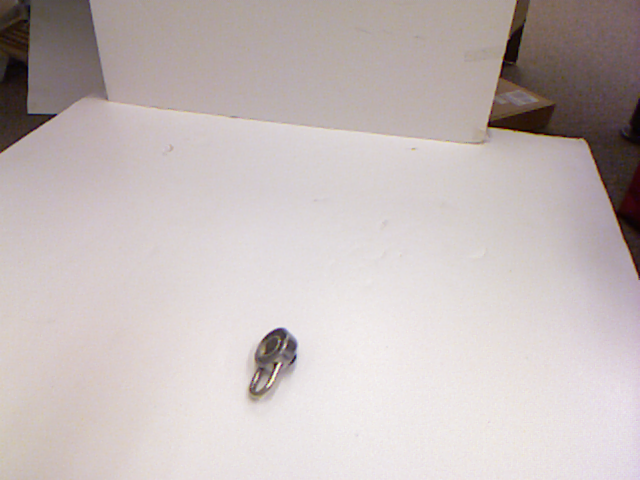

In [3]:
IMAGE_PATH = "assets/grasp_pose/cornell_pcd0948r.png"
img = Image.open(IMAGE_PATH).convert("RGB")
display(img)

2. Generate message

In [4]:
instruction = "How should the robot grasp the object?"

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": IMAGE_PATH},
            {"type": "text", "text": instruction}
        ]
    }
]
print(messages)

[{'role': 'user', 'content': [{'type': 'image', 'image': 'assets/grasp_pose/cornell_pcd0948r.png'}, {'type': 'text', 'text': 'How should the robot grasp the object?'}]}]


3. Infer with RynnBrain

In [5]:
inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
)
inputs = inputs.to(model.device)

generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]
print(output_text)

Gripper coordinates: <grasp pose> (593, 826), (253, 828), (252, 711), (592, 709) </grasp pose>


4. Visualization

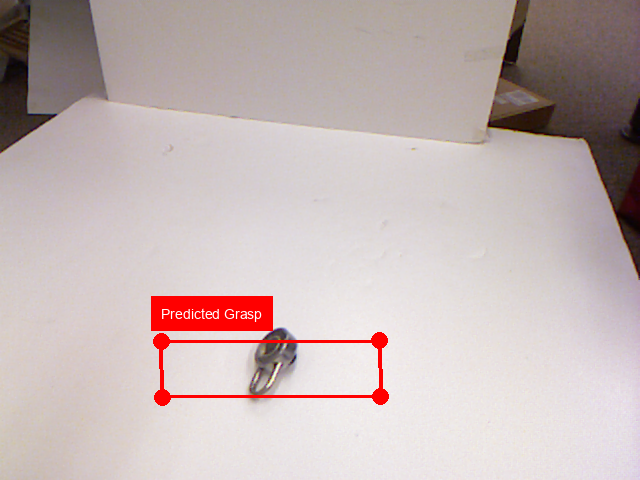

In [6]:
corners_norm = parse_grasp_pose(output_text)
if corners_norm:
    img = Image.open(IMAGE_PATH).convert("RGB")
    w, h = img.size
    corners_px = convert_corners_to_pixels(corners_norm, w, h)
    draw_grasp_rectangle(img, corners_px, color="red", line_width=4, show_width=600, text="Predicted Grasp")
else:
    print("Failed to parse grasp pose from output")

### Example 2: Cornell Grasp - Object-Specific (IoU: 54.32%)

1. Load and visualize the image

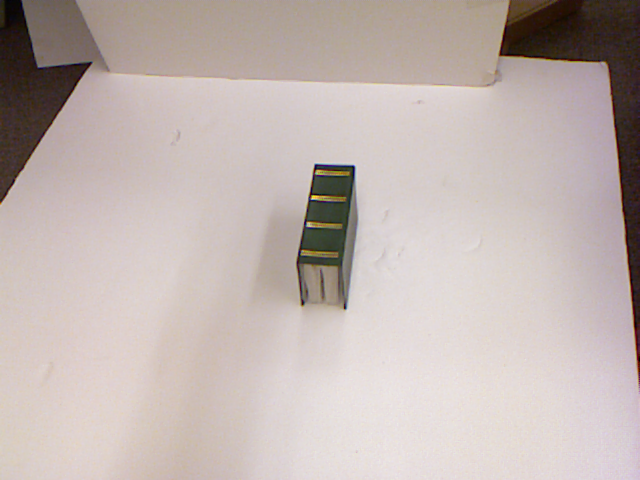

In [7]:
IMAGE_PATH_2 = "assets/grasp_pose/cornell_pcd0632r.png"
img2 = Image.open(IMAGE_PATH_2).convert("RGB")
display(img2)

2. Generate message with object-specific instruction

In [8]:
instruction_2 = "Calculate the grasping pose to successfully pick up the object."

messages_2 = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": IMAGE_PATH_2},
            {"type": "text", "text": instruction_2}
        ]
    }
]
print(messages_2)

[{'role': 'user', 'content': [{'type': 'image', 'image': 'assets/grasp_pose/cornell_pcd0632r.png'}, {'type': 'text', 'text': 'Calculate the grasping pose to successfully pick up the object.'}]}]


3. Infer with RynnBrain

In [9]:
inputs_2 = processor.apply_chat_template(
    messages_2,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
)
inputs_2 = inputs_2.to(model.device)

generated_ids_2 = model.generate(**inputs_2, max_new_tokens=128)
generated_ids_trimmed_2 = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs_2.input_ids, generated_ids_2)
]
output_text_2 = processor.batch_decode(
    generated_ids_trimmed_2, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]
print(output_text_2)

The robot should grasp at <grasp pose> (374, 404), (683, 446), (672, 531), (363, 489) </grasp pose>


4. Visualization

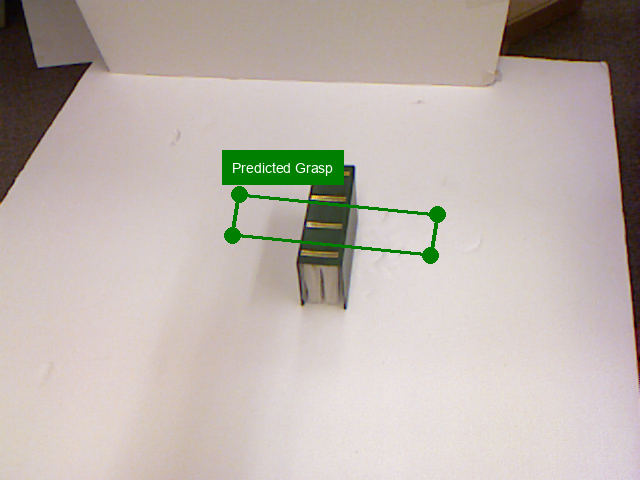

In [10]:
corners_norm_2 = parse_grasp_pose(output_text_2)
if corners_norm_2:
    img2 = Image.open(IMAGE_PATH_2).convert("RGB")
    w, h = img2.size
    corners_px_2 = convert_corners_to_pixels(corners_norm_2, w, h)
    draw_grasp_rectangle(img2, corners_px_2, color="green", line_width=4, show_width=600, text="Predicted Grasp")
else:
    print("Failed to parse grasp pose from output")

### Example 3: VMRD Dataset - Apple Grasping (IoU: 61.31%)

1. Load and visualize the image

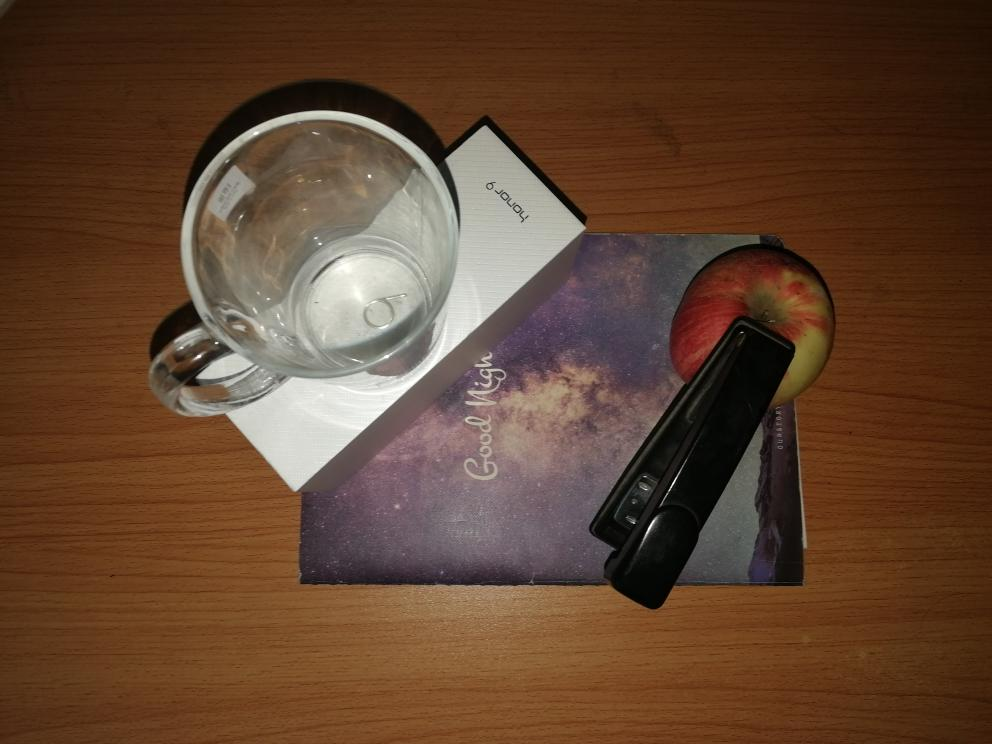

In [11]:
IMAGE_PATH_3 = "assets/grasp_pose/vmrd_00388.jpg"
img3 = Image.open(IMAGE_PATH_3).convert("RGB")
display(img3)

2. Generate message with specific object

In [12]:
instruction_3 = "How should the robot grasp the apple?"

messages_3 = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": IMAGE_PATH_3},
            {"type": "text", "text": instruction_3}
        ]
    }
]
print(messages_3)

[{'role': 'user', 'content': [{'type': 'image', 'image': 'assets/grasp_pose/vmrd_00388.jpg'}, {'type': 'text', 'text': 'How should the robot grasp the apple?'}]}]


3. Infer with RynnBrain

In [13]:
inputs_3 = processor.apply_chat_template(
    messages_3,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
)
inputs_3 = inputs_3.to(model.device)

generated_ids_3 = model.generate(**inputs_3, max_new_tokens=128)
generated_ids_trimmed_3 = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs_3.input_ids, generated_ids_3)
]
output_text_3 = processor.batch_decode(
    generated_ids_trimmed_3, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]
print(output_text_3)

Optimal grasping position: <grasp pose> (931, 487), (619, 506), (613, 408), (925, 389) </grasp pose>


4. Visualization

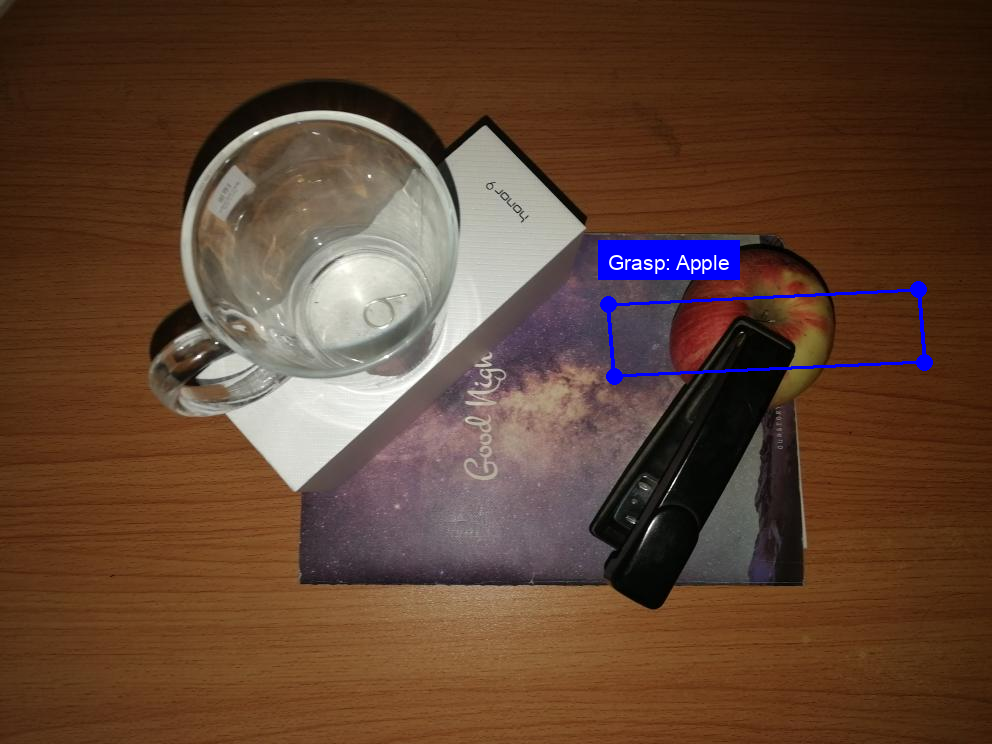

In [14]:
corners_norm_3 = parse_grasp_pose(output_text_3)
if corners_norm_3:
    img3 = Image.open(IMAGE_PATH_3).convert("RGB")
    w, h = img3.size
    corners_px_3 = convert_corners_to_pixels(corners_norm_3, w, h)
    draw_grasp_rectangle(img3, corners_px_3, color="blue", line_width=4, show_width=600, text="Grasp: Apple")
else:
    print("Failed to parse grasp pose from output")

### Example 4: VMRD Dataset - Mobile Phone (IoU: 60.25%)

1. Load and visualize the image

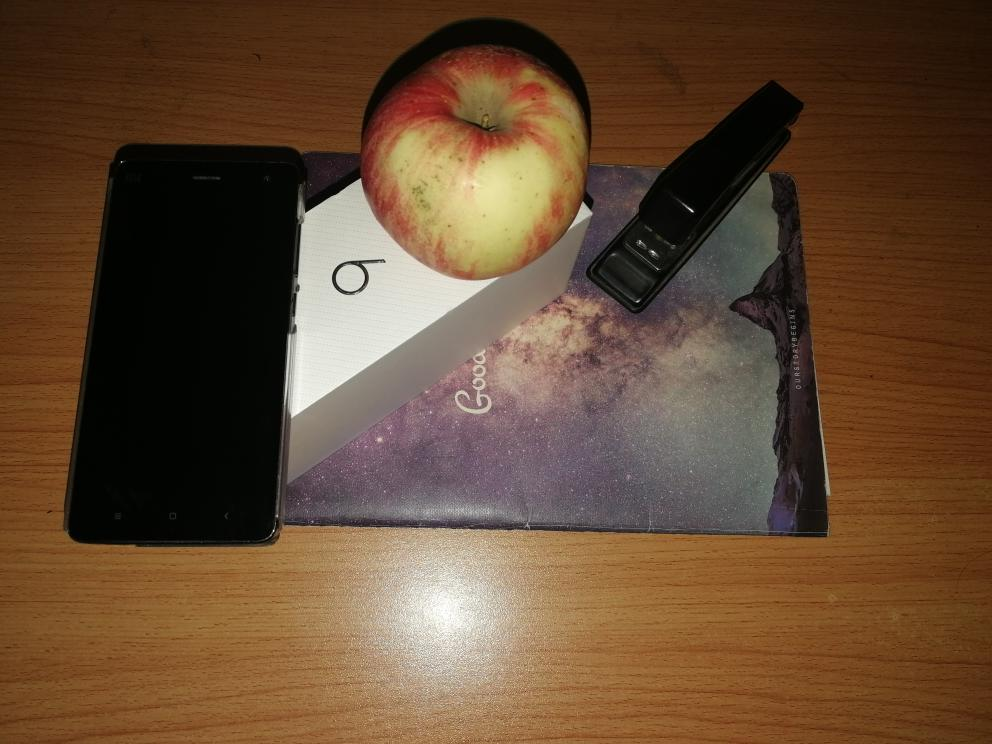

In [15]:
IMAGE_PATH_4 = "assets/grasp_pose/vmrd_00397.jpg"
img4 = Image.open(IMAGE_PATH_4).convert("RGB")
display(img4)

2. Generate message with scene context

In [16]:
instruction_4 = "In this scene, how should the robot grasp the mobile phone?"

messages_4 = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": IMAGE_PATH_4},
            {"type": "text", "text": instruction_4}
        ]
    }
]
print(messages_4)

[{'role': 'user', 'content': [{'type': 'image', 'image': 'assets/grasp_pose/vmrd_00397.jpg'}, {'type': 'text', 'text': 'In this scene, how should the robot grasp the mobile phone?'}]}]


3. Infer with RynnBrain

In [17]:
inputs_4 = processor.apply_chat_template(
    messages_4,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
)
inputs_4 = inputs_4.to(model.device)

generated_ids_4 = model.generate(**inputs_4, max_new_tokens=128)
generated_ids_trimmed_4 = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs_4.input_ids, generated_ids_4)
]
output_text_4 = processor.batch_decode(
    generated_ids_trimmed_4, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]
print(output_text_4)

The grasping pose is <grasp pose> (115, 165), (442, 285), (417, 352), (90, 231) </grasp pose>


4. Visualization

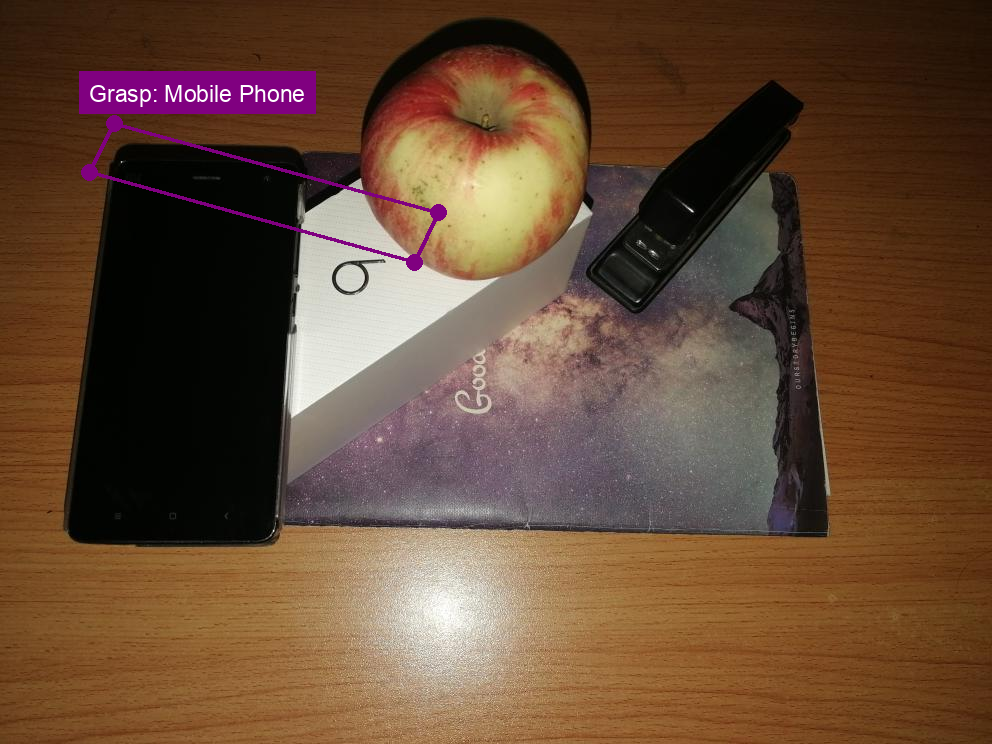

In [18]:
corners_norm_4 = parse_grasp_pose(output_text_4)
if corners_norm_4:
    img4 = Image.open(IMAGE_PATH_4).convert("RGB")
    w, h = img4.size
    corners_px_4 = convert_corners_to_pixels(corners_norm_4, w, h)
    draw_grasp_rectangle(img4, corners_px_4, color="purple", line_width=4, show_width=600, text="Grasp: Mobile Phone")
else:
    print("Failed to parse grasp pose from output")

### Summary

This cookbook demonstrates RynnBrain's grasp pose prediction capability:

- **Output Format**: 4 corner points defining a rotated rectangle: `<grasp pose> (x1, y1), (x2, y2), (x3, y3), (x4, y4) </grasp pose>`
- **Coordinate System**: Normalized to [0, 1000] range, independent of image resolution
- **Flexibility**: Supports various instruction formats (generic, object-specific, scene-based)
- **Performance**: Achieves >60% IoU on challenging grasp detection benchmarks (Cornell, VMRD)
- **Applications**: Object manipulation, robotic picking, warehouse automation, household robotics

The predicted grasp rectangles encode:
- **Position**: Where to place the gripper
- **Orientation**: Angle of approach
- **Width**: Opening distance for the gripper fingers

These examples show successful grasps on diverse objects (kitchen items, electronics) with different shapes and orientations.